In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

In [498]:
import gym
from gym import spaces
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

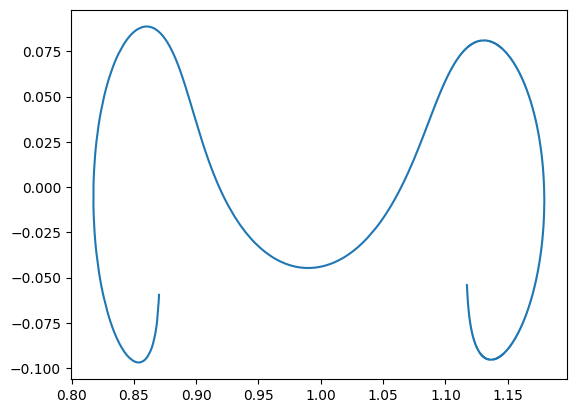

In [499]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [500]:
# three body problem env
import gym
from gym import spaces
import numpy as np

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-150, high=0, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        force = action[0] * env.state[2:] + action[1] * env.state[:2]
        a_x = force[0]
        a_y = force[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y

        x = x + xdot*self.dt
        y = y + ydot*self.dt
        
        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        reward = 1 - np.linalg.norm(self.position - self.trajectory[self.steps], axis=0)
        done = self.steps >= self.max_steps
        if np.linalg.norm(self.position[0:2] - self.trajectory[-1, 0:2]) < 0.01:
            done = True
            reward = 1000
        if self.steps > 1000:
            done = True
            reward = -1000
        if np.linalg.norm(self.state) > 2:
            done = True
            reward = -1000

        # print(self.state, reward, done, self.position)
        return 10000*self.state, reward, done, self.position

    def position2state(self):
        # find nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
    
    def reset(self):
        self.position = self.trajectory[0]   
        self.steps = 0
        self.position2state()
        return 10000*self.state
    
    def render(self):
        pass

    def close(self):
        pass

    



In [501]:
# problem = "Pendulum-v1"
# env = gym.make(problem)
env = three_body_env(trajectory)
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  2
Max Value of Action ->  0.0
Min Value of Action ->  -150.0


In [502]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [503]:

class Buffer:
    def __init__(self, buffer_capacity=1000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1][0]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [504]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(128, activation="relu")(inputs)
    out = layers.Dense(128, activation="tanh")(out)
    outputs = layers.Dense(2, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    # model = tf.keras.models.load_model('model.h5')
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [505]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [506]:
std_dev = 100
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.2
actor_lr = 0.1

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

In [507]:
env = three_body_env(trajectory)

Episode * 0 * Avg Reward is ==> 1384.9233145178775
Episode * 1 * Avg Reward is ==> 1385.7033375778121
Episode * 2 * Avg Reward is ==> 680.1537785907095
Episode * 3 * Avg Reward is ==> 282.4194964250612
Episode * 4 * Avg Reward is ==> 43.77892712567225
Episode * 5 * Avg Reward is ==> -115.31478574058706
Episode * 6 * Avg Reward is ==> -228.9531520736294
Episode * 7 * Avg Reward is ==> -314.1819268234112
Episode * 8 * Avg Reward is ==> -380.4709738510192
Episode * 9 * Avg Reward is ==> -433.64567435281026
Episode * 10 * Avg Reward is ==> -477.0218266909078
Episode * 11 * Avg Reward is ==> -513.1686203059891
Episode * 12 * Avg Reward is ==> -543.7543687495195
Episode * 13 * Avg Reward is ==> -566.6274950737351
Episode * 14 * Avg Reward is ==> -438.0020805616702
Episode * 15 * Avg Reward is ==> -326.0195610331861
Episode * 16 * Avg Reward is ==> -226.8371057190891
Episode * 17 * Avg Reward is ==> -137.70068994908576
Episode * 18 * Avg Reward is ==> -57.76093666769778
Episode * 19 * Avg Rew

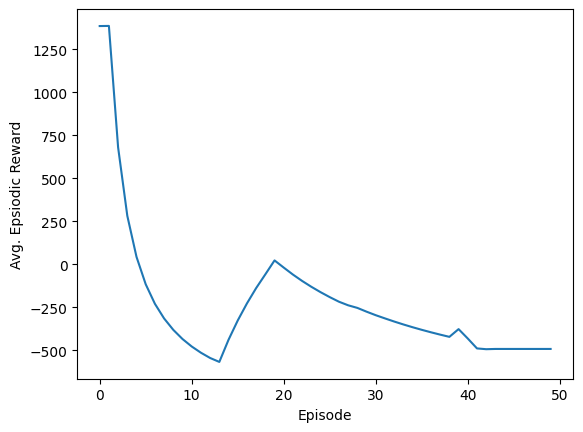

In [511]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes*5):

    prev_state= env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action[0])

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

[ 2.22956084 -0.79458722  0.57693471 -1.66668695]
871


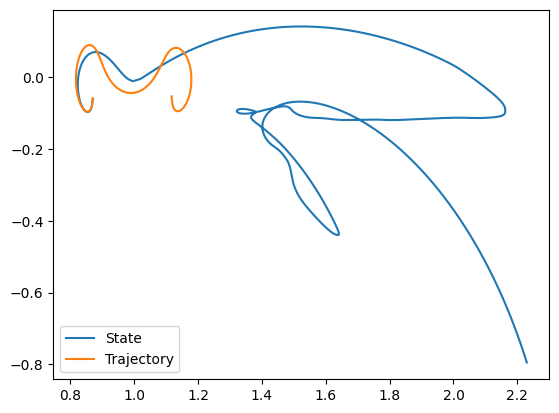

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


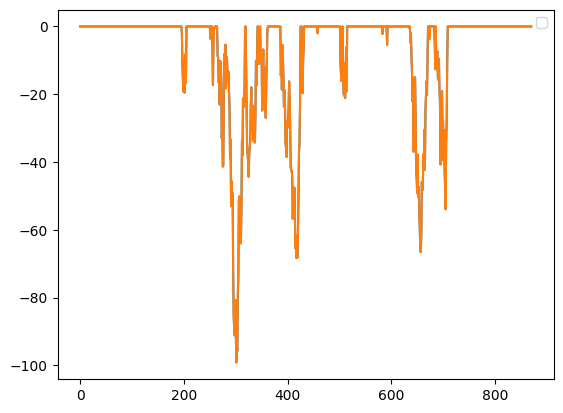

871


In [516]:
## run simulation
prev_state= env.reset()
state_array = []
action_array = []
while True:
    # env.render()
    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
    action = policy(tf_prev_state, ou_noise)
    state, reward, done, info = env.step(action[0])
    state_array.append(env.position)
    action_array.append(action)
    if done:
        break
    prev_state = state

state_array = np.array(state_array)
action_array = np.array(action_array)
plt.plot(state_array[:,0], state_array[:,1], label='State')
plt.plot(trajectory[:,0], trajectory[:,1], label='Trajectory')
print(state_array[-1, :])
print(env.steps)
plt.legend()
plt.show()

# plot action
plt.plot(action_array.reshape(len(action_array), 2))
plt.legend()
plt.show()

print(len(action_array))

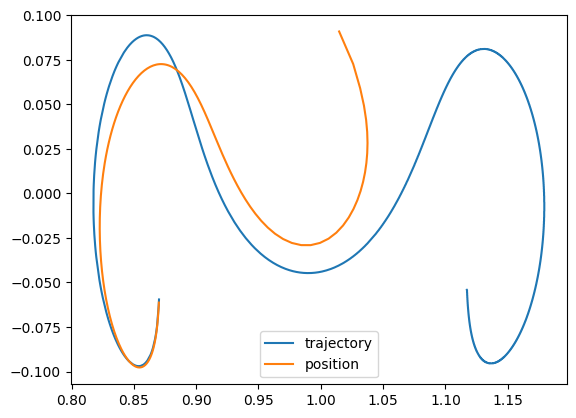

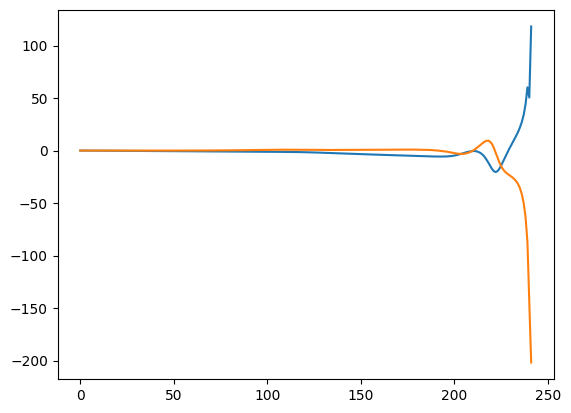

In [510]:
env = three_body_env(trajectory)
env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = -120 * env.state[2:] - 70 * env.state[:2]
    # print(action)
    action_array.append(action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(env.position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)
